<a href="https://colab.research.google.com/github/cedeerwe/brutalna-akademia/blob/master/notebooks/04_kamen_papier_noznice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Úloha č.1

Začneme netradične. Vašou prvou úlohou je zdolať hru, ktorú nájdete [tu](https://cedeerwe.github.io/read-my-mind/).

# Pomocný kód

Základný kód na modelovanie súbojov kameň-papier-nožnice. Bude sa vám hodiť na ďalšiu úlohu.

In [0]:
from abc import ABC, abstractmethod
from typing import List, Dict
from enum import Enum
import random
import pandas as pd
import functools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class Result(Enum):
    win = 1
    draw = 0.5
    loss = 0

class Weapon(Enum):
    rock = 0
    paper = 1
    scissors = 2

class Battle:
    def __init__(self, me: Weapon, opponent: Weapon):
        self.me = me
        self.opponent = opponent
        self.result = battle(me, opponent)
    
    def __repr__(self):
        return f"Battle({self.me}, {self.opponent}, {self.result})"

# outputs the result of battling two weapons
def battle(w1: Weapon, w2: Weapon) -> Result:
    result = (w1.value - w2.value) % 3
    if result == 0:
        return Result.draw
    elif result == 1:
        return Result.win
    else:
        return Result.loss

# outputs a weapon uniformly at random
def random_weapon():
    num = random.random() * 3
    if num < 1:
        return Weapon.rock
    elif num < 2:
        return Weapon.paper
    else:
        return Weapon.scissors

# outputs a weapon randomly using given proportions
# random_weapon_proportional(1, 2, 3) gives you:
#   rock with probability 1/6
#   paper with probability 1/3
#   scissors with probability 1/2
def random_weapon_proportional(rocks, papers, scissors):
    if rocks <= 0 and papers <= 0 and scissors <= 0:
        return random_weapon()
    sum_props = rocks + papers + scissors
    num = random.random() * sum_props
    if num < rocks:
        return Weapon.rock
    elif num < rocks + papers:
        return Weapon.paper
    else:
        return Weapon.scissors

# outputs the weapon, which beats the output weapon
# beats(Weapon.rock) = Weapon.paper
def beats(w: Weapon) -> Weapon:
    return Weapon((w.value + 1) % 3)

# counts the number of usages of each of the weapons by the opponent
def count_opponent_weapons(history: List[Battle]) -> Dict[Weapon, int]:
    result = {Weapon.rock: 0, Weapon.paper: 0, Weapon.scissors: 0}
    for battle in history:
        result[battle.opponent] += 1
    return result

# counts the number of usages of each of the weapons by us
def count_me_weapons(history: List[Battle]) -> Dict[Weapon, int]:
    result = {Weapon.rock: 0, Weapon.paper: 0, Weapon.scissors: 0}
    for battle in history:
        result[battle.me] += 1
    return result

# counts the number of wins for each of the weapons
def count_wins(history: List[Battle]) -> Dict[Weapon, int]:
    result = {Weapon.rock: 0, Weapon.paper: 0, Weapon.scissors: 0}
    for battle in history:
        if battle.result == Result.win:
            result[battle.me] += 1
        elif battle.result == Result.loss:
            result[battle.opponent] += 1
    return result

# General player
class Player(ABC):
    @property
    @abstractmethod
    def name(self):
        pass

    @property
    def short_name(self):
        return self.name.split(" ")[0]

    @abstractmethod
    def generate(self, history: List[Battle]) -> Weapon:
        pass

    def battle_player(self, player, history_me: List[Battle], history_opponent: List[Battle]):
        me = self.generate(history_me)
        opponent = player.generate(history_opponent)
        history_me.append(Battle(me, opponent))
        history_opponent.append(Battle(opponent, me))

    def simulate_match(self, player, num_battles: int) -> List[Battle]:
        self.reset()
        player.reset()
        history_me = []
        history_opponent = []
        for i in range(num_battles):
            self.battle_player(player, history_me, history_opponent)
        return history_me

    def point_percentage(self, player, num_battles: int, num_matches: int):
        return np.mean([
                 history_point_percentage(self.simulate_match(player, num_battles)) 
                 for i in range(num_matches)
                 ])

    def reset(self):
        self.__init__()

# UTILS

def history_point_percentage(history: List[Battle]) -> float:
    return functools.reduce(
        lambda prev, battle: battle.result.value + prev, history, 0
        ) / len(history)

def simulate(players: List[Player], num_battles: int, num_matches: int):
    return pd.DataFrame(
        {
            player1.short_name: {
                player2.name: player2.point_percentage(player1, num_battles, num_matches) 
                for player2 in players
            } for player1 in players
        }
    )

def plot_result(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(15,10))
    pal = sns.color_palette("bwr", 33)
    sns.heatmap(df, annot=True, cmap=pal, vmin=0, vmax=1)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

def show_results(player: Player, opponents: List[Player], num_battles: int, num_matches: int):
    plot_result(simulate([*opponents, player], num_battles, num_matches))

def average_result(player: Player, opponents: List[Player], num_battles: int, num_matches: int):
    return sum(
        player.point_percentage(opponent, num_battles, num_matches)
        for opponent in opponents
    ) / len(opponents)

## Kódy súperov

Poprosíme na začiatku neotvárať a nepozerať, kým nebudete naozaj vedieť, čo naozaj robia jednotliví hráči.

In [0]:
## Opponents

class SingleWeapon(Player):
    name = "Alan the Almighty"
    def __init__(self):
        self.weapon = random_weapon()

    def generate(self, history: List[Battle]) -> Weapon:
        return self.weapon

class BeatLast(Player):
    name = "Beatrice the Brutal"
    def generate(self, history: List[Battle]) -> Weapon:
        if len(history) == 0:
            return random_weapon()
        else:
            return beats(history[-1].opponent)

class RandomAlternate(Player):
    name = "Cedric the Confused"
    def generate(self, history: List[Battle]) -> Weapon:
        if len(history) == 0:
            return random_weapon()
        last_weapon = history[-1].me
        if last_weapon == Weapon.rock:
            return random_weapon_proportional(0, 1, 1)
        elif last_weapon == Weapon.paper:
            return random_weapon_proportional(1, 0, 1)
        else:
            return random_weapon_proportional(1, 1, 0)

class TwoWeapons(Player):
    name = "Damian the Delicious"
    def __init__(self):
        omitted_weapon = random_weapon()
        if omitted_weapon == Weapon.rock:
            self.proportions = [0, 1, 1]
        elif omitted_weapon == Weapon.paper:
            self.proportions = [1, 0, 1]
        else:
            self.proportions = [1, 1, 0]

    def generate(self, history: List[Battle]) -> Weapon:
        return random_weapon_proportional(*self.proportions)

class MostWinning(Player):
    name = "Edward the Educated"

    def generate(self, history: List[Battle]) -> Weapon:
        wins = count_wins(history)
        max_wins = max(wins.values())
        if max_wins == 0:
            return random_weapon()
        threshold = lambda x: x if x == max_wins else 0
        return random_weapon_proportional(
            threshold(wins[Weapon.rock]),
            threshold(wins[Weapon.paper]),
            threshold(wins[Weapon.scissors])
        )

class RandomGuy(Player):
    name = "Florian the Fallen"
    def generate(self, history: List[Battle]) -> Weapon:
        return random_weapon()

class FavoriteWeapon(Player):
    name = "Gregory the Generous"
    def __init__(self):
        favorite_weapon = random_weapon()
        if favorite_weapon == Weapon.rock:
            self.proportions = [2, 1, 1]
        elif favorite_weapon == Weapon.paper:
            self.proportions = [1, 2, 1]
        else:
            self.proportions = [1, 1, 2]

    def generate(self, history: List[Battle]):
        return random_weapon_proportional(*self.proportions)

class ProportionalBeat(Player):
    name = "Hugo the Hilarious"
    def generate(self, history: List[Battle]):
        if len(history) == 0:
            return random_weapon()
        our_arsenal = count_me_weapons(history)
        return beats(beats(random_weapon_proportional(
            our_arsenal[Weapon.rock],
            our_arsenal[Weapon.paper],
            our_arsenal[Weapon.scissors]
        )))

ALL_OPPONENTS = [
    SingleWeapon(),
    BeatLast(),
    RandomAlternate(),
    TwoWeapons(),
    MostWinning(),
    RandomGuy(),
    FavoriteWeapon(),
    ProportionalBeat()
]

# Úloha č.2

Naprogramujte vlastného hráča, ktorý spraví čo najlepší výsledok proti všetkým súperom.

In [0]:
# YOUR PLAYER

class YourPlayer(Player):
    name = "You"
    def generate(self, history: List[Battle]) -> Weapon:
        return random_weapon() # na začiatok máte k dispozícií náhodného hráča

In [4]:
NUM_BATTLES = 20
NUM_MATCHES = 100
average_result(YourPlayer(), ALL_OPPONENTS, NUM_BATTLES, NUM_MATCHES)

0.5015624999999999

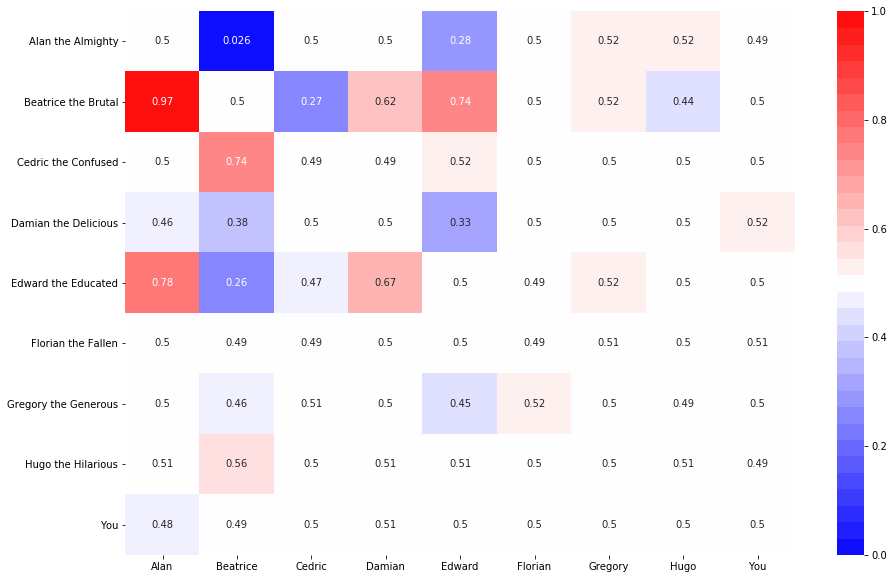

In [5]:
show_results(YourPlayer(), ALL_OPPONENTS, NUM_BATTLES, NUM_MATCHES)

# Domáca úloha č.1

Naprogramujte hráča, ktorý poráža všetkých súperov a zároveň aj vášho hráča z úlohy č. 2.

In [0]:
# YOUR PLAYER, BUT BETTER

class YourPlayerButBetter(Player):
    name = "YouButBetter"
    def generate(self, history: List[Battle]) -> Weapon:
        return random_weapon() # na začiatok máte k dispozícií náhodného hráča

In [7]:
NUM_BATTLES = 20
NUM_MATCHES = 100
average_result(YourPlayerButBetter(), [*ALL_OPPONENTS, YourPlayer()], NUM_BATTLES, NUM_MATCHES)

0.5027500000000001

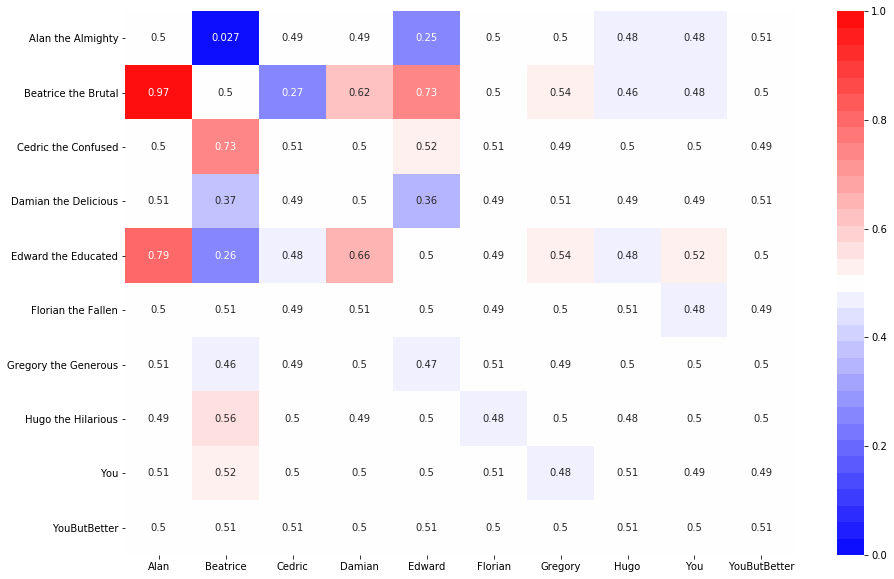

In [8]:
show_results(YourPlayerButBetter(), [*ALL_OPPONENTS, YourPlayer()], NUM_BATTLES, NUM_MATCHES)

# Domáca úloha č.2

Vypýtajte si naprogramovaných hráčov od vašich kamarátov a skúste ich poraziť.

In [0]:
# YOUR FRIENDS

class Friend1(Player):
    name = "Friend1"
    def generate(self, history: List[Battle]) -> Weapon:
        return random_weapon()

class Friend2(Player):
    name = "Friend2"
    def generate(self, history: List[Battle]) -> Weapon:
        return random_weapon()

class Friend3(Player):
    name = "Friend3"
    def generate(self, history: List[Battle]) -> Weapon:
        return random_weapon()

# ...etc

class YourBest(Player):
    name = "YourBest"
    def generate(self, history: List[Battle]) -> Weapon:
        return random_weapon()

In [10]:
NUM_BATTLES = 20
NUM_MATCHES = 100
your_opponents = [
    *ALL_OPPONENTS,
    YourPlayer(),
    YourPlayerButBetter(),
    Friend1(),
    Friend2(),
    Friend3()
]
average_result(YourBest(), your_opponents, NUM_BATTLES, NUM_MATCHES)

0.4978461538461539

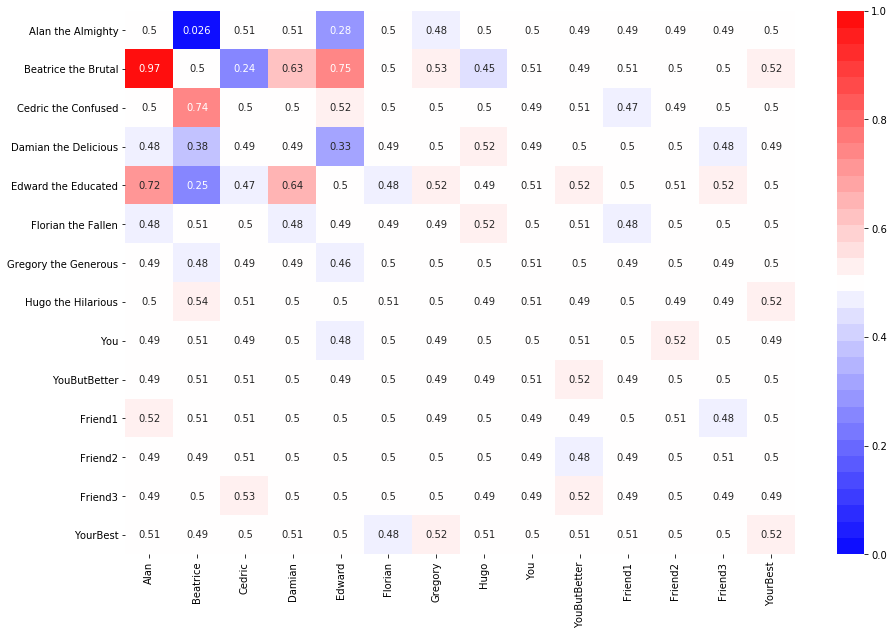

In [11]:
show_results(YourBest(), your_opponents, NUM_BATTLES, NUM_MATCHES)